In [1]:
import os

# Set Spark version and URL
spark_version = "3.4.1"
spark_filename = f"spark-{spark_version}-bin-hadoop3"
mirror_url = f"https://archive.apache.org/dist/spark/spark-{spark_version}/{spark_filename}.tgz"

# Install Java
!apt-get update
!apt-get install openjdk-11-jdk-headless -qq > /dev/null

# Download Spark from stable archive mirror
!wget -q {mirror_url}

# Extract and move
!tar -xzf {spark_filename}.tgz
!mv {spark_filename} /content/spark

# Install findspark
!pip install -q findspark

# Set environment variables
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark"

# Initialize Spark
import findspark
findspark.init()

from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("ColabSpark").getOrCreate()

# Test
spark.range(5).show()

Get:1 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Hit:3 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:4 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Hit:7 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Get:9 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:11 https://r2u.stat.illinois.edu/ubuntu jammy/main amd64 Packages [2,723 kB]
Get:12 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [1,675 kB]
Get:13 https://r2u.stat.illinois.edu/ubuntu jamm

In [3]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, hour, dayofmonth, month, to_timestamp
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
import pandas as pd

# ------------------------
# Start Spark Session
# ------------------------
spark = SparkSession.builder \
    .appName("FireCategoryPrediction") \
    .getOrCreate()

# ------------------------
# Load CSV
# ------------------------
df_raw = spark.read.csv("fire_incidents.csv", sep=",", header=True)

df_raw.show(5, truncate=False)



+---------+-----------+----------------------+-------------+---------+------------------+--------+--------------------------+------------------------------------------------+------------------+
|Case_Year|Case Number|Incident_DateTime     |Borough      |Battalion|Community_District|Precinct|Incident_Classification   |Cause_Fire_Description                          |Fire_Code_Category|
+---------+-----------+----------------------+-------------+---------+------------------+--------+--------------------------+------------------------------------------------+------------------+
|2016     |40001      |01/01/2016 12:08:00 AM|Queens       |50       |8                 |107     |MD Residential Structure  |Smoking (Cigarette/Cigar)                       |Smoking           |
|2016     |50001      |01/01/2016 12:13:00 AM|Staten Island|21       |2                 |122     |PD Residential Structure  |Incendiary - Combustible Material               |Incendiary        |
|2016     |40002      |01/01/2

In [4]:
# Rename columns
df = df_raw.toDF(
    "Year", "IncidentNumber", "Timestamp", "Borough", "Battalion",
    "Division", "Station", "Structure Type", "Cause of Incident", "Fire Category"
)

# Parse Timestamp correctly
df = df.withColumn("Timestamp", to_timestamp("Timestamp", "MM/dd/yyyy hh:mm:ss a"))

# Drop rows with bad timestamps
df = df.na.drop(subset=["Timestamp"])

# Add time features
df = df.withColumn("Hour", hour("Timestamp")) \
       .withColumn("Day", dayofmonth("Timestamp")) \
       .withColumn("Month", month("Timestamp"))

# Drop unused columns
df = df.drop("Timestamp", "IncidentNumber")

# Show cleaned and engineered data
df.show(5, truncate=False)

+----+-------------+---------+--------+-------+--------------------------+------------------------------------------------+-------------+----+---+-----+
|Year|Borough      |Battalion|Division|Station|Structure Type            |Cause of Incident                               |Fire Category|Hour|Day|Month|
+----+-------------+---------+--------+-------+--------------------------+------------------------------------------------+-------------+----+---+-----+
|2016|Queens       |50       |8       |107    |MD Residential Structure  |Smoking (Cigarette/Cigar)                       |Smoking      |0   |1  |1    |
|2016|Staten Island|21       |2       |122    |PD Residential Structure  |Incendiary - Combustible Material               |Incendiary   |0   |1  |1    |
|2016|Queens       |37       |5       |104    |MD Residential Structure  |Incendiary - Combustible Material               |Incendiary   |0   |1  |1    |
|2016|Bronx        |15       |12      |47     |Burn Notification (Albany)|Albany B

In [5]:
# ------------------------
# Handle Missing Values in Categorical Columns
# ------------------------

# Check for missing values in categorical columns
df.select("Borough", "Structure Type", "Cause of Incident", "Fire Category").describe().show()

# Drop rows with null values in categorical columns
df = df.dropna(subset=["Borough", "Structure Type", "Cause of Incident", "Fire Category"])

# ------------------------
# Encode Categorical Variables
# ------------------------

# Define indexers for categorical columns, ensuring invalid data is skipped
indexers = [
    StringIndexer(inputCol="Borough", outputCol="BoroughIndex", handleInvalid="skip"),
    StringIndexer(inputCol="Structure Type", outputCol="StructureTypeIndex", handleInvalid="skip"),
    StringIndexer(inputCol="Cause of Incident", outputCol="CauseofIncidentIndex", handleInvalid="skip"),
    StringIndexer(inputCol="Fire Category", outputCol="FireCategoryIndex", handleInvalid="skip")
]

# Apply indexers to the DataFrame
# Fit and transform only once for each indexer
# Check if the output column already exists before transforming
if "BoroughIndex" not in df.columns:
    df = indexers[0].fit(df).transform(df)  # Borough
if "StructureTypeIndex" not in df.columns:
    df = indexers[1].fit(df).transform(df)  # Structure Type
if "CauseofIncidentIndex" not in df.columns:
    df = indexers[2].fit(df).transform(df)  # Cause of Incident
if "FireCategoryIndex" not in df.columns:
    df = indexers[3].fit(df).transform(df)  # Fire Category




# ------------------------
# Prepare Features
# ------------------------

# Prepare feature columns
feature_cols = [
    "BoroughIndex", "StructureTypeIndex", "CauseofIncidentIndex",
    "Hour", "Day", "Month"
]

# Assemble the features into a feature vector
# Check if 'features' column already exists before applying VectorAssembler
if "features" not in df.columns:
    assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
    df = assembler.transform(df)

# Show the final DataFrame with the 'features' column
df.select("Borough", "Structure Type", "Cause of Incident", "Fire Category", "features").show(5, truncate=False)


+-------+-------------+--------------+------------------+-------------+
|summary|      Borough|Structure Type| Cause of Incident|Fire Category|
+-------+-------------+--------------+------------------+-------------+
|  count|        53481|         52914|             53668|        53680|
|   mean|         null|          null|              null|         null|
| stddev|         null|          null|              null|         null|
|    min|        Bronx|      Aircraft|       Aerosol Can|   Appliances|
|    max|Staten Island|       Vehicle|Washer/Dryer Combo|      Smoking|
+-------+-------------+--------------+------------------+-------------+

+-------------+--------------------------+------------------------------------------------+-------------+-------------------------+
|Borough      |Structure Type            |Cause of Incident                               |Fire Category|features                 |
+-------------+--------------------------+---------------------------------------------

In [6]:
# ------------------------
# Train/Test Split
# ------------------------
train_df, test_df = df.randomSplit([0.8, 0.2], seed=42)


Training model with numTrees=20, maxDepth=5
➡️  Accuracy: 0.6544

Training model with numTrees=20, maxDepth=10
➡️  Accuracy: 0.7767

Training model with numTrees=20, maxDepth=15
➡️  Accuracy: 0.8570

Training model with numTrees=50, maxDepth=5
➡️  Accuracy: 0.6548

Training model with numTrees=50, maxDepth=10
➡️  Accuracy: 0.7807

Training model with numTrees=50, maxDepth=15
➡️  Accuracy: 0.8681

Training model with numTrees=100, maxDepth=5
➡️  Accuracy: 0.6520

Training model with numTrees=100, maxDepth=10
➡️  Accuracy: 0.7853

Training model with numTrees=100, maxDepth=15
➡️  Accuracy: 0.8676



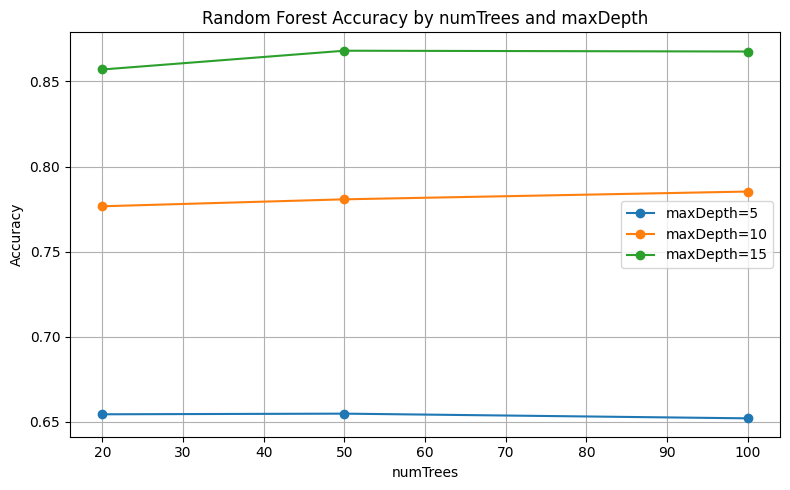

In [7]:
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
import pandas as pd
import matplotlib.pyplot as plt

# ------------------------
# Model Optimization & Evaluation Tracking
# ------------------------

# Hyperparameter grid
num_trees_list = [20, 50, 100]
max_depth_list = [5, 10, 15]

# Evaluator
evaluator = MulticlassClassificationEvaluator(
    labelCol="CauseofIncidentIndex", predictionCol="prediction", metricName="accuracy"
)

# Store all runs
results = []

# Loop over hyperparameters
for num_trees in num_trees_list:
    for max_depth in max_depth_list:
        print(f"Training model with numTrees={num_trees}, maxDepth={max_depth}")

        # Initialize Random Forest with current params
        rf = RandomForestClassifier(
            labelCol="CauseofIncidentIndex",
            featuresCol="features",
            numTrees=num_trees,
            maxDepth=max_depth,
            maxBins=200  # Adjusted for high-cardinality features
        )

        # Train model
        model = rf.fit(train_df)

        # Predict on test set
        predictions = model.transform(test_df)

        # Evaluate
        accuracy = evaluator.evaluate(predictions)
        print(f"➡️  Accuracy: {accuracy:.4f}\n")

        # Save results
        results.append({
            "numTrees": num_trees,
            "maxDepth": max_depth,
            "accuracy": accuracy
        })

# Save results to CSV
performance_df = pd.DataFrame(results)
performance_df.to_csv("rf_model_performance.csv", index=False)

# Optional: plot
plt.figure(figsize=(8, 5))
for depth in max_depth_list:
    subset = performance_df[performance_df["maxDepth"] == depth]
    plt.plot(subset["numTrees"], subset["accuracy"], marker='o', label=f"maxDepth={depth}")

plt.title("Random Forest Accuracy by numTrees and maxDepth")
plt.xlabel("numTrees")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [8]:
# ------------------------
# Evaluation
# ------------------------
evaluator = MulticlassClassificationEvaluator(
    labelCol="CauseofIncidentIndex", predictionCol="prediction", metricName="accuracy"
)
accuracy = evaluator.evaluate(predictions)

print(f"\n Final Model Accuracy: {accuracy:.4f}")

# Optional: Save model performance
performance_df = pd.DataFrame([{
    "numTrees": 100,
    "maxDepth": 10,
    "accuracy": accuracy
}])
performance_df.to_csv("spark_model_performance.csv", index=False)


 Final Model Accuracy: 0.8676


In [10]:
from sklearn.metrics import classification_report
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
import pandas as pd # Keep import for potential future use or clarity

# Evaluate additional metrics
precision_evaluator = MulticlassClassificationEvaluator(
    labelCol="CauseofIncidentIndex", predictionCol="prediction", metricName="weightedPrecision"
)
recall_evaluator = MulticlassClassificationEvaluator(
    labelCol="CauseofIncidentIndex", predictionCol="prediction", metricName="weightedRecall"
)
f1_evaluator = MulticlassClassificationEvaluator(
    labelCol="CauseofIncidentIndex", predictionCol="prediction", metricName="f1"
)

precision = precision_evaluator.evaluate(predictions)
recall = recall_evaluator.evaluate(predictions)
f1 = f1_evaluator.evaluate(predictions)

# Get true and predicted labels from Spark DataFrame
# Moved these lines from the next cell
y_true = predictions.select("CauseofIncidentIndex").rdd.flatMap(lambda x: x).collect()
y_pred = predictions.select("prediction").rdd.flatMap(lambda x: x).collect()

# Print classification report
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      2499
         1.0       1.00      1.00      1.00      1367
         2.0       1.00      1.00      1.00      1011
         3.0       1.00      1.00      1.00       846
         4.0       1.00      1.00      1.00       571
         5.0       1.00      1.00      1.00       371
         6.0       1.00      1.00      1.00       256
         7.0       0.99      1.00      1.00       209
         8.0       0.99      0.98      0.98       167
         9.0       1.00      0.94      0.97       181
        10.0       0.91      0.99      0.95       140
        11.0       1.00      0.99      1.00       140
        12.0       1.00      0.99      0.99       142
        13.0       0.97      0.99      0.98       141
        14.0       0.85      1.00      0.92       134
        15.0       0.97      0.84      0.90       114
        16.0       0.74      0.93      0.82        94
        17.0       0.92    

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [11]:
predictions.groupBy("CauseofIncidentIndex", "prediction").count().show()


+--------------------+----------+-----+
|CauseofIncidentIndex|prediction|count|
+--------------------+----------+-----+
|                24.0|      35.0|    1|
|                65.0|      20.0|    2|
|                24.0|      33.0|    1|
|                90.0|      51.0|    1|
|                65.0|      65.0|    1|
|                80.0|      35.0|    1|
|                40.0|      32.0|    1|
|                33.0|      16.0|    1|
|                42.0|      23.0|    1|
|                39.0|      67.0|    1|
|                64.0|      29.0|    1|
|                69.0|      51.0|    1|
|                34.0|      21.0|    9|
|                41.0|      30.0|    1|
|                15.0|      16.0|   12|
|                17.0|      66.0|    1|
|                94.0|      28.0|    1|
|                66.0|      56.0|    1|
|                70.0|      70.0|   11|
|                23.0|      24.0|    1|
+--------------------+----------+-----+
only showing top 20 rows



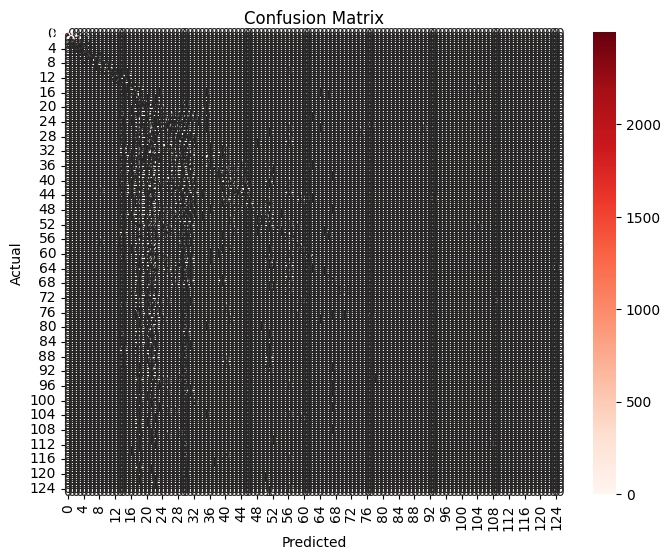

In [12]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
# Get true and predicted labels from Spark DataFrame
y_true = predictions.select("CauseofIncidentIndex").rdd.flatMap(lambda x: x).collect()
y_pred = predictions.select("prediction").rdd.flatMap(lambda x: x).collect()

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Reds")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [13]:
# ------------------------
# Stop Spark Session
# ------------------------
spark.stop()